In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import TransformerDecoder, TransformerDecoderLayer
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Lấy data từ drive
IMG_SIZE = (850, 150)
DATASET_PATH = "C:/Users/ADMIN/Documents/data_line/data-line/data-line/data"
label_Path = "C:/Users/ADMIN/Documents/data_line/data-line/data-line/label.txt"

In [3]:
import math

class PositionEmbedding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionEmbedding, self).__init__()

        # Tạo một tensor chứa thông tin về vị trí của các phần tử trong chuỗi
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)  # Áp dụng sin với chỉ số chẵn
        pe[:, 1::2] = torch.cos(position * div_term)  # Áp dụng cos với chỉ số lẻ
        pe = pe.unsqueeze(0)  # Thêm một chiều batch_size
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (seq_len, batch_size, embed_dim)
        seq_len = x.size(0)
        return x + self.pe[:, :seq_len]

class CNNFeatureExtractor(nn.Module):
    def __init__(self, embed_dim=256, in_channels=3):
        super(CNNFeatureExtractor, self).__init__()

        # Xây dựng CNN backbone (có thể dùng ResNet hoặc CNN tùy chỉnh)
        self.cnn = nn.Sequential(
            # Layer 1: Conv + BatchNorm + ReLU
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Giảm kích thước: (64, 64, 16)

            # Layer 2: Conv + BatchNorm + ReLU
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Giảm kích thước: (128, 32, 8)

            # Layer 3: Conv + BatchNorm + ReLU
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),  # Giảm chiều cao: (256, 16, 8)

            # Layer 4: Conv cuối để trích xuất đặc trưng
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Fully connected layer để chuyển đổi sang embed_dim
        self.fc = nn.Linear(512, embed_dim)

        # Thêm Position Embedding vào mô hình
        self.position_embedding = PositionEmbedding(embed_dim)

    def forward(self, x):
        # Trích xuất đặc trưng bằng CNN
        features = self.cnn(x)  # (batch_size, channels, height, width)
        # Ví dụ: (batch_size, 512, 16, 8)

        # Chuyển đổi để phù hợp với Transformer
        batch_size, channels, height, width = features.size()
        features = features.permute(0, 3, 1, 2)  # (batch_size, width, channels, height)
        features = features.reshape(batch_size, width, channels * height)  # (batch_size, width, channels * height)

        # Áp dụng fully connected layer để giảm chiều về embed_dim
        features = self.fc(features)  # (batch_size, width, embed_dim)

        # Chuyển thành định dạng Transformer cần: (sequence_length, batch_size, embed_dim)
        features = features.permute(1, 0, 2)  # (width, batch_size, embed_dim)

        # Áp dụng Position Embedding
        features = self.position_embedding(features)

        return features


In [4]:
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        assert d_model % num_heads == 0, "d_model phải chia hết cho num_heads"

        # Trainable projection layers
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)

        # Output linear layer
        self.dense = nn.Linear(d_model, d_model)

    def attention(self, query, key, value, mask=None):
        # query, key, value shape: (batch, num_heads, seq_len, d_head)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(key.size(-1))  # scaled dot product

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, value)
        return output, weights

    def split_heads(self, x):
        # x: (batch_size, seq_len, d_model)
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.d_head)
        return x.transpose(1, 2)  # (batch_size, num_heads, seq_len, d_head)

    def merge_heads(self, x):
        # x: (batch_size, num_heads, seq_len, d_head)
        batch_size, num_heads, seq_len, d_head = x.size()
        x = x.transpose(1, 2)  # (batch_size, seq_len, num_heads, d_head)
        return x.reshape(batch_size, seq_len, num_heads * d_head)  # (batch_size, seq_len, d_model)

    def forward(self, q, k, v, mask=None):
        Q = self.Wq(q)
        K = self.Wk(k)
        V = self.Wv(v)

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        out, attn_weights = self.attention(Q, K, V, mask)
        out = self.merge_heads(out)
        out = self.dense(out)
        return out, attn_weights


In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout_rate)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask=None):
        attn_output, attn_weights = self.mha(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x, attn_weights

In [6]:
class Encoder(nn.Module):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([
            EncoderBlock(d_model, num_heads, hidden_dim, dropout_rate)
            for _ in range(num_blocks)
        ])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, features, mask=None):
        x = self.dropout(features)  # Nhận đặc trưng từ CNN
        for block in self.blocks:
            x, weights = block(x, mask)
        return x, weights

In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.mha1 = nn.MultiheadAttention(d_model, num_heads, dropout=dropout_rate)
        self.mha2 = nn.MultiheadAttention(d_model, num_heads, dropout=dropout_rate)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, encoder_output, target, decoder_mask=None, memory_mask=None):
        attn1_output, attn1_weights = self.mha1(target, target, target, attn_mask=decoder_mask)
        x = self.norm1(target + self.dropout(attn1_output))
        attn2_output, attn2_weights = self.mha2(x, encoder_output, encoder_output, attn_mask=memory_mask)
        x = self.norm2(x + self.dropout(attn2_output))
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_output))
        return x, attn2_weights

In [8]:
class Decoder(nn.Module):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, target_vocab_size, max_seq_len, dropout_rate=0.1):
        super().__init__()
        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, hidden_dim, dropout_rate)
            for _ in range(num_blocks)
        ])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, encoder_output, target, decoder_mask=None, memory_mask=None):
        tgt_embed = self.embedding(target) + self.pos_encoding[:, :target.size(0), :]
        x = self.dropout(tgt_embed)
        for block in self.blocks:
            x, weights = block(encoder_output, x, decoder_mask, memory_mask)
        return x, weights

In [9]:
class TransformerOCR(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=1024):
        super(TransformerOCR, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)

        output = self.transformer(src, tgt)
        output = self.fc_out(output)

        return output

In [10]:
special_tokens = ["<PAD>", "<SOS>", "<EOS>"]
alphabet = "aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ "
characters = special_tokens + list(alphabet)
vocab = {char: idx for idx, char in enumerate(characters)}
vocab_size = len(vocab)

In [11]:
class OCRDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = self.load_labels(label_file)
        self.transform = transform

    def load_labels(self, label_file):
        labels = []
        with open(label_file, "r", encoding="utf-8") as f:
            for line in f.readlines():
                image_name, label = line.strip().split(" ", 1)
                image_name = os.path.basename(image_name)
                labels.append((image_name, label))
        return labels

    def encode_label(self, label):
        return [vocab["<SOS>"]] + [vocab[c] for c in label if c in vocab] + [vocab["<EOS>"]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name, label = self.labels[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None: #bỏ qua ảnh bị lỗi
          print(f"BỎ QUA ảnh bị lỗi: {image_path}")
          return self.__getitem__((idx + 1) % len(self.labels))
        image = cv2.resize(image, (128, 32))
        if self.transform:
            image = self.transform(image)
        label_encoded = self.encode_label(label)
        return image, torch.tensor(label_encoded, dtype=torch.long)

In [12]:
def collate_fn(batch):
    images, labels = zip(*batch)
    max_len = max(len(label) for label in labels)
    padded_labels = [
        torch.cat([label, torch.full((max_len - len(label),), vocab["<PAD>"], dtype=torch.long)] )
        for label in labels
    ]
    return torch.stack(images), torch.stack(padded_labels)


In [13]:
IMG_DIR = "C:/Users/ADMIN/Documents/data_line/data-line/data-line/data"
validation_split = "C:/Users/ADMIN/Documents/data_line/data-line/data-line/validation.txt"
train="C:/Users/ADMIN/Documents/data_line/data-line/data-line/train.txt"
test="C:/Users/ADMIN/Documents/data_line/data-line/data-line/test.txt"

In [14]:
BATCH_SIZE = 32
EPOCHS = 25
device = "cuda" if torch.cuda.is_available() else exit("CUDA is required!")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [15]:
# Tạo từ điển nghịch đảo để ánh xạ từ index → ký tự
inv_vocab = {v: k for k, v in vocab.items()}

# Hàm chuyển tensor (chuỗi index) thành chuỗi văn bản
def decode(tensor):
    tokens = [inv_vocab[idx.item()] for idx in tensor if idx.item() not in [vocab["<PAD>"], vocab["<SOS>"], vocab["<EOS>"]]]
    return ''.join(tokens)

In [ ]:
from jiwer import cer
import matplotlib.pyplot as plt

def evaluate_model(label_file, model, model_name="Model"):
    val_dataset = OCRDataset(IMG_DIR, label_file, transform)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    #load model
    #model = TransformerOCR(vocab_size).to(device)
    #model.load_state_dict(torch.load(model_path)) # type: ignore
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])
    val_loss = 0
    cer_scores = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            tgt_input = labels[:, :-1].long()
            tgt_output = labels[:, 1:].long()

            output = model(tgt_input, tgt_input)
            loss = criterion(output.reshape(-1, vocab_size), tgt_output.reshape(-1))
            val_loss += loss.item()

            pred_indices = output.argmax(dim=-1)
            for pred_seq, true_seq in zip(pred_indices, tgt_output):
                pred_text = decode(pred_seq)
                true_text = decode(true_seq)
                cer_scores.append(cer(true_text, pred_text))

    avg_loss = val_loss / len(val_loader)
    avg_cer = sum(cer_scores) / len(cer_scores)
    print(f"\n[{model_name}] Validation Loss: {avg_loss:.4f}, CER: {avg_cer:.4f}")

    return avg_loss, avg_cer

In [17]:
def train_model(label_file, model_name):
    dataset = OCRDataset(IMG_DIR, label_file, transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    model = TransformerOCR(vocab_size).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            tgt_input = labels[:, :-1].long()
            tgt_output = labels[:, 1:].long()
            optimizer.zero_grad()
            output = model(tgt_input, tgt_input)
            loss = criterion(output.reshape(-1, vocab_size), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)
        print(f"{model_name} - Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}")

        # Gọi evaluate_model (đưa model thay vì model_path)
        val_loss, val_cer = evaluate_model(validation_split, model, model_name=model_name)
        val_losses.append(val_loss)

        torch.save(model.state_dict(), f"{model_name}_epoch_{epoch + 1}.pth")

    return train_losses, val_losses


In [18]:
train_losses, val_losses = train_model(train, "Model_1")

Model_1 - Epoch [1/25], Train Loss: 4.0379

[Model_1] Validation Loss: 3.5904, CER: 0.7212
Model_1 - Epoch [2/25], Train Loss: 3.1480

[Model_1] Validation Loss: 2.9073, CER: 0.6616
Model_1 - Epoch [3/25], Train Loss: 2.7113

[Model_1] Validation Loss: 2.6394, CER: 0.6310
Model_1 - Epoch [4/25], Train Loss: 2.4871

[Model_1] Validation Loss: 2.5043, CER: 0.6241
Model_1 - Epoch [5/25], Train Loss: 2.3482

[Model_1] Validation Loss: 2.3936, CER: 0.6048
Model_1 - Epoch [6/25], Train Loss: 2.2408

[Model_1] Validation Loss: 2.3045, CER: 0.5965
Model_1 - Epoch [7/25], Train Loss: 2.1488

[Model_1] Validation Loss: 2.2319, CER: 0.5855
Model_1 - Epoch [8/25], Train Loss: 2.0766

[Model_1] Validation Loss: 2.1928, CER: 0.5831
Model_1 - Epoch [9/25], Train Loss: 2.0143

[Model_1] Validation Loss: 2.1536, CER: 0.5795
Model_1 - Epoch [10/25], Train Loss: 1.9507

[Model_1] Validation Loss: 2.0850, CER: 0.5709
Model_1 - Epoch [11/25], Train Loss: 1.8996

[Model_1] Validation Loss: 2.0507, CER: 0.56

In [22]:
model_path = "Model_1_epoch_25.pth"
val_loss, val_cer = evaluate_model(validation_split, model_path, model_name="Model_1")


[Model_1] Validation Loss: 1.8582, CER: 0.5411


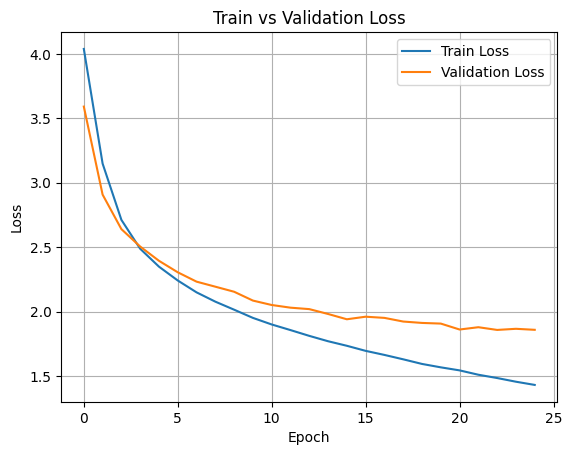

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
